In [3]:
# Import necessary libraries
import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import verde as vd
import multiprocessing
from itertools import accumulate

from tqdm import tqdm

import xarray as xr

import time, array, random

from deap import base, creator, tools, algorithms

from CODES.modeling import create_seismic_model,calculate_parameters,calculate_parameters_from_vs
from CODES.dispersion_curves import create_velocity_model_from_profile,create_velocity_model_from_profile_vs,estimate_disp_from_velocity_model

# Text based on:

- Gallagher, K., & Sambridge, M. (1994). **Genetic algorithms: a powerful tool for large-scale nonlinear optimization problems**. Comput. Geosci., 20(7–8), 1229–1236.
- Fortin, F. A., Rainville, F. M., Gardner, M., Parizeau, M., and Gagné, C. **DEAP: Evolutionary Algorithms Made Easy**, Journal of Machine Learning Research, pp. 2171-2175, no 13, jul 2012.
- Haskell, N. A. ,1953, **The dispersion of surface waves on multi-layered media**, Bull. Seism. Soc. Am. 43, 17-34.
- Xia, J., Miller, R. D.,  and Park,C. B., 1999, **Estimation of near‐surface shear‐wave velocity by inversion of Rayleigh waves**, GEOPHYSICS 1999 64:3, 691-700.
- Yamanaka, H., and H. Ishida, 1996, **Application of genetic algorithms to an inversion of surface-wave dispersion data**, Bulletin of the Seismological Society of America, 86, 436–444.

# Inversion of Surface-Wave Dispersion Data

**Rayleigh-wave phase velocity is the function of four parameters (Xia et al, 1999):**
    - S-wave velocity;
    - P-wave velocity;
    - Density; and
    - Layer thickness.

In the process of retrieving a 2D Vs profile from a 3D layered earth model, the primary step involves extracting 1D Vs profiles at multiple locations across the study area. Since surface wave analysis is most sensitive to vertical variations in Vs, the lateral variations are effectively averaged out during data processing. This results in a 1D Vs model, often referred to as a layered earth model, where Vs is determined as a function of depth, while other parameters such as Vp and density (ρ) may be either included or held constant. Each 1D Vs profile is assigned to the central location of its respective receiver spread, representing the most characteristic subsurface structure at that point. By accumulating multiple such profiles, each tagged with a unique surface coordinate, a 2D Vs profile is constructed through spatial interpolation. This method enables a continuous Vs representation along a given transect while maintaining the fundamental assumption of a layered earth model.


# Inputs and outputs

In [4]:
folder_model_name = 'MCP1'

### Directory for saving model and other related stuffs: 

In [5]:
data_path = 'OUTPUT/'+folder_model_name+'/DATA/'

### Directory for saving figures: 

In [6]:
figures_path = 'OUTPUT/'+folder_model_name+'/FIGURES/'

---------

# **Comparison and final analysis:**

In [29]:
df_inversion = pd.read_feather(data_path+'inversion_.feather')
df_inversion

,Vs,thick,misfit,ngen,misfit_min,profile,inversion
0,"[166.10999999999999, 685.98, 145.0, 370.0, 996...","[0.43, 0.36, 0.36, 0.49, 0.54]","[2.244086888314125, 0.8121801118690332, 0.4319...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0.015743,1,1
1,"[200.48, 625.1200000000001, 141.0, 518.0, 997.93]","[0.42, 0.35, 0.39, 0.41, 0.4]","[2.2658006393094476, 0.8538279264241068, 0.449...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0.013976,2,1
2,"[258.97, 538.0, 143.0, 718.0, 999.0]","[0.36, 0.42, 0.39, 0.44, 0.37]","[2.287255035496638, 0.823654474260467, 0.45940...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0.009851,3,1
3,"[440.64, 122.0, 558.9300000000002, 334.0, 1003.0]","[0.5, 0.37, 0.31999999999999995, 0.48, 0.24]","[2.2144684987068284, 0.8304899697011875, 0.436...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0.006530,4,1
4,"[459.92, 153.0, 185.08, 511.0, 1001.45]","[0.5, 0.33, 0.31, 0.39999999999999997, 0.17]","[2.2560648991941896, 0.8778040555487183, 0.473...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0.003516,5,1
5,"[473.04999999999995, 318.19, 142.0, 375.520000...","[0.33, 0.31, 0.37, 0.35000000000000003, 0.28]","[2.2600823604351854, 0.8593450817020671, 0.467...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0.004951,6,1
6,"[458.72999999999996, 248.28, 152.0, 1080.02, 9...","[0.4, 0.38, 0.37, 0.45, 0.46]","[2.2561560416691733, 0.857518858938236, 0.4733...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0.011604,7,1
7,"[469.0, 225.0, 159.0, 890.46, 998.0]","[0.43, 0.33, 0.48, 0.5599999999999999, 0.4]","[2.293565514907069, 0.8549693172840279, 0.4559...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0.004714,8,1
8,"[502.35, 262.45000000000005, 153.0, 747.9, 997...","[0.32, 0.42, 0.47, 0.3, 0.45]","[2.2523143831296064, 0.8420557932875514, 0.460...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0.006295,9,1
9,"[464.83, 136.0, 282.0, 897.87, 994.66]","[0.49, 0.43, 0.49, 0.38, 0.37]","[2.226460279935633, 0.8162589721388863, 0.4626...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0.010578,10,1


In [40]:
np.cumsum(dativ[1]['thick'])

array([0.43, 0.79, 1.15, 1.64, 2.18])

Text(0.5, 1.0, 'Vs profiles evolution')

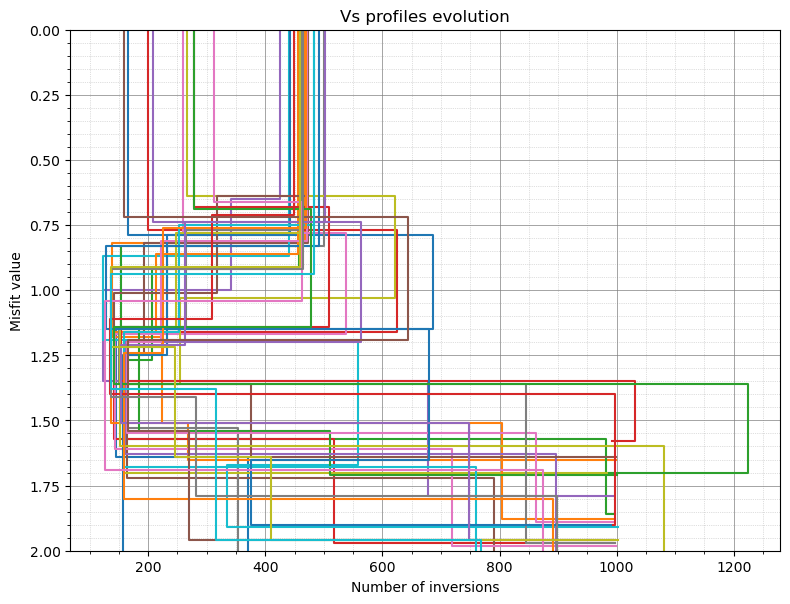

In [48]:
fig, ax = plt.subplots(figsize=(8, 6))
for prof_n in df_inversion['profile'].unique():
    for dativ in df_inversion[df_inversion['profile'] == prof_n].iterrows():
        ax.step(np.insert(dativ[1]['Vs'],0,dativ[1]['Vs'][0]),np.insert(np.cumsum(dativ[1]['thick']),0,0), '-')  # Sem o label
        
ax.set_xlabel('Number of inversions')
ax.set_ylabel('Misfit value')
ax.set_ylim(2,0)
ax.grid(True)
plt.tight_layout()
ax.minorticks_on()
ax.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
ax.grid(which='minor', color='gray', linestyle=':', linewidth=0.5, alpha=0.5)
ax.set_title('Vs profiles evolution')
      

In [27]:
df_inversion['Vs']

0     [166.10999999999999, 685.98, 145.0, 370.0, 996...
1     [200.48, 625.1200000000001, 141.0, 518.0, 997.93]
2                  [258.97, 538.0, 143.0, 718.0, 999.0]
3     [440.64, 122.0, 558.9300000000002, 334.0, 1003.0]
4               [459.92, 153.0, 185.08, 511.0, 1001.45]
5     [473.04999999999995, 318.19, 142.0, 375.520000...
6     [458.72999999999996, 248.28, 152.0, 1080.02, 9...
7                  [469.0, 225.0, 159.0, 890.46, 998.0]
8     [502.35, 262.45000000000005, 153.0, 747.9, 997...
9                [464.83, 136.0, 282.0, 897.87, 994.66]
10               [467.79, 139.0, 222.93, 268.0, 999.04]
11                 [425.0, 342.0, 122.0, 677.42, 995.0]
12              [499.43, 231.77, 164.0, 353.0, 1000.05]
13             [442.46, 232.22, 157.0, 1026.59, 996.06]
14    [278.0, 508.86999999999995, 154.0, 1031.53, 99...
15    [470.78000000000003, 221.0, 164.0, 862.44, 998.0]
16    [483.90000000000003, 252.0, 158.0, 760.47, 100...
17    [278.88, 478.0, 140.9, 1223.8799999999999,

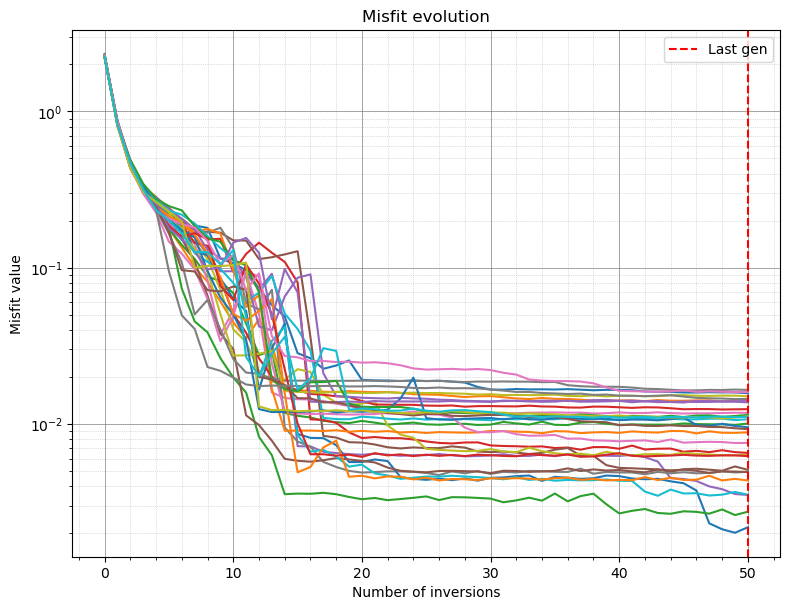

In [8]:
fig, ax = plt.subplots(figsize=(8, 6))
for dativ in df_inversion.iterrows():
    ax.semilogy(dativ[1]['ngen'], dativ[1]['misfit'], '-')  # Sem o label
        
ax.set_xlabel('Number of inversions')
ax.set_ylabel('Misfit value')
ax.axvline(x=len(dativ[1]['ngen'])-1, color='red', linestyle='--', label='Last gen')
ax.legend(loc='upper right')
ax.grid(True)
plt.tight_layout()
ax.minorticks_on()
ax.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
ax.grid(which='minor', color='gray', linestyle=':', linewidth=0.5, alpha=0.5)
ax.set_title('Misfit evolution')
      
fig.savefig(figures_path+'misfit_total_.png', dpi=300)

In [9]:
lst_receptor = np.arange(1, 50-1,5)*2

# The best inversion (lowest misfit) - Predicted data

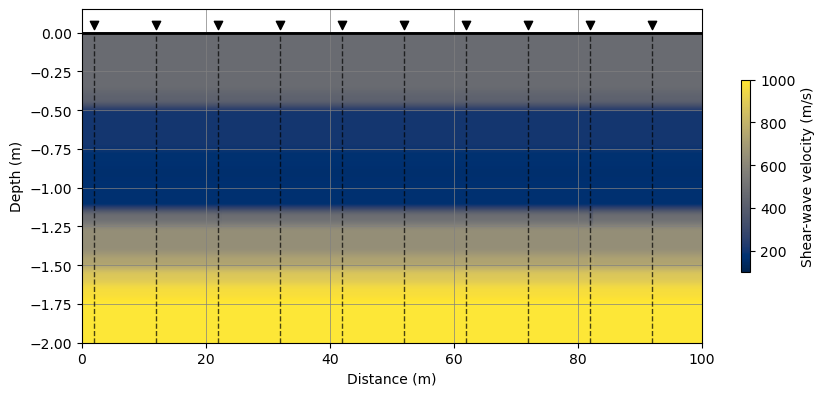

In [17]:
grid_lst = []
for uni in df_inversion['profile'].unique():
    dativ = df_inversion[df_inversion['profile'] == uni]
    depth_result_lst = []
    velocity_result_lst = []
    receptor_result_lst = []
            
    depth_interval = -0.05

    # Selecting the two lowest values:
    df_misfit_2 = dativ.nsmallest(1, 'misfit_min')
    
    for dativ in df_misfit_2.iterrows():

        thickness_inv = dativ[1]['thick']
        vels_inv = dativ[1]['Vs']
        
        depths = [0]+[-j for j in list(accumulate(thickness_inv))]
            
        depths_fine = []
        vels_fine = []
        
        # Iterate through depth intervals
        for j in range(len(depths) - 1):
            # Create a new depth array within the interval with finer sampling
            depths_interval = np.arange(depths[j], depths[j + 1], depth_interval)
        
            depths_fine.extend(depths_interval)
            # Repeat the velocity value within the interval
            vels_fine.extend([vels_inv[j]] * len(depths_interval))

        receptor_result_lst.append([lst_receptor[uni-1]]*len(vels_fine))
        depth_result_lst.append(depths_fine)
        velocity_result_lst.append(vels_fine)
    receptor_result_lst = np.array([item for sublist in receptor_result_lst for item in sublist])
    depth_result_lst = np.array([item for sublist in depth_result_lst for item in sublist])
    velocity_result_lst = np.array([item for sublist in velocity_result_lst for item in sublist])
    
    # We'll test this on the air temperature data from Texas
    coordinates = (receptor_result_lst, depth_result_lst)
    velocitys = velocity_result_lst
    region = (0,100,-2,0)
    
    spacing = (0.1,0.1)
    
    # Now we can set up a gridder for the decimated data
    grd = vd.KNeighbors().fit(coordinates, velocitys)

    
    # The 'grid' method can still make a geographic grid if we pass in a projection
    # function that converts lon, lat into the easting, northing coordinates that
    # we used in 'fit'. This can be any function that takes lon, lat and returns x,
    # y. In our case, it'll be the 'projection' variable that we created above.
    # We'll also set the names of the grid dimensions and the name the data
    # variable in our grid (the default would be 'scalars', which isn't very
    # informative).
    grid = grd.grid(region=region,spacing=spacing,dims=["depth","receptor"],data_names="velocity")
    grid_lst.append(grid)
# Concatenar ao longo de uma nova dimensão e calcular a média
predicted_grid = xr.concat(grid_lst, dim="new_dim").mean(dim="new_dim")


# plotting 
fig,ax = plt.subplots(1, 1, figsize=(10, 5))

im = plt.imshow(predicted_grid.velocity.data, cmap='cividis',extent=[0, 100, -2.0, 0],vmin=100,vmax=1000,aspect=25,origin='lower')

for ix in lst_receptor:
    ax.vlines(x=ix,ymin=-2.0,ymax=0,colors='k',lw=1.0,ls='--',alpha=0.7)
    ax.scatter(x=ix,y=0.05,color='k',marker='v')

ax.hlines(y=0,xmin=0,xmax=100,colors='k',lw=2,ls='-',alpha=1)
ax.set_xlabel('Distance (m)')
ax.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
ax.grid(which='minor', color='gray', linestyle=':', linewidth=0.5, alpha=0.5)
ax.set_ylabel('Depth (m)')
plt.colorbar(im, ax=ax,fraction=0.15, shrink=0.5,label='Shear-wave velocity (m/s)')
fig.savefig(figures_path+'inversion_slice_and_receptors.png')

# Observed data

In [18]:
filename_feather = data_path+'observed_data.feather'

obs_data = pd.read_feather(filename_feather)

In [19]:
depth_result_lst = []
velocity_result_lst = []
receptor_result_lst = []

depth_interval = -0.05

for dativ in obs_data.iterrows():

    depths = dativ[1]['depth'].tolist()[::-1]
    vels_mean = dativ[1]['velocity_s'].tolist()[::-1]

    depths_fine = []
    vels_fine = []

    # Iterate through depth intervals
    for j in range(len(depths) - 1):
        # Create a new depth array within the interval with finer sampling
        depths_interval = np.arange(depths[j], depths[j + 1], depth_interval)

        depths_fine.extend(depths_interval)
        # Repeat the velocity value within the interval
        vels_fine.extend([vels_mean[j]] * len(depths_interval))

    receptor_result_lst.append([lst_receptor[dativ[0]]]*len(vels_fine))
    depth_result_lst.append(depths_fine)
    velocity_result_lst.append(vels_fine)
    
receptor_result_lst = np.array([item for sublist in receptor_result_lst for item in sublist])
depth_result_lst = np.array([item for sublist in depth_result_lst for item in sublist])
velocity_result_lst = np.array([item for sublist in velocity_result_lst for item in sublist])

# We'll test this on the air temperature data from Texas
coordinates = (receptor_result_lst, depth_result_lst)
velocitys = velocity_result_lst
region = (0,100,-2,0)

spacing = (0.1,0.1)

# Now we can set up a gridder for the decimated data
grd = vd.KNeighbors().fit(coordinates, velocitys)

# The 'grid' method can still make a geographic grid if we pass in a projection
# function that converts lon, lat into the easting, northing coordinates that
# we used in 'fit'. This can be any function that takes lon, lat and returns x,
# y. In our case, it'll be the 'projection' variable that we created above.
# We'll also set the names of the grid dimensions and the name the data
# variable in our grid (the default would be 'scalars', which isn't very
# informative).
observed_grid = grd.grid(
    region=region,
    spacing=spacing,
    dims=["depth","receptor"],
    data_names="velocity",
)

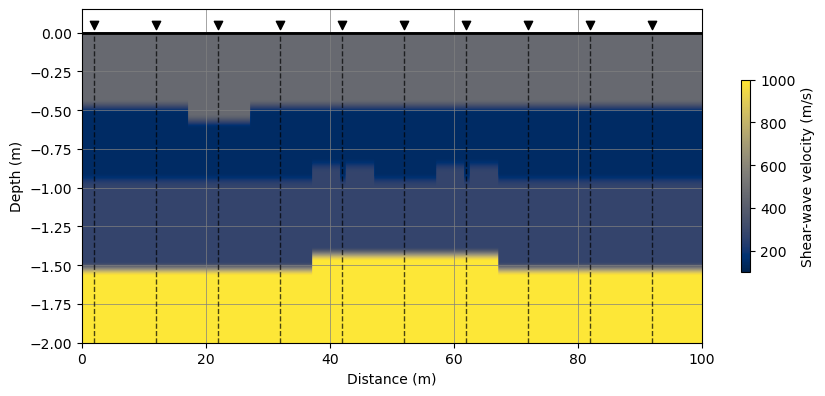

In [20]:
fig,ax = plt.subplots(1, 1, figsize=(10, 5))

im = plt.imshow(observed_grid.velocity.data, cmap='cividis',extent=[0, 100, -2.0, 0],vmin=100,vmax=1000,aspect=25,origin='lower')

for idx,ix in enumerate(lst_receptor):
    ax.vlines(x=ix,ymin=-2.0,ymax=0,colors='k',lw=1.0,ls='--',alpha=0.7)
    ax.scatter(x=ix,y=0.05,color='k',marker='v')

ax.hlines(y=0,xmin=0,xmax=100,colors='k',lw=2,ls='-',alpha=1)
ax.set_xlabel('Distance (m)')
ax.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
ax.grid(which='minor', color='gray', linestyle=':', linewidth=0.5, alpha=0.5)
ax.set_ylabel('Depth (m)')
plt.colorbar(im, ax=ax,fraction=0.15, shrink=0.5,label='Shear-wave velocity (m/s)')
fig.savefig(figures_path+'observed_slice_and_receptors.png')

# Analisys

In [21]:
deviation_grid = predicted_grid - observed_grid

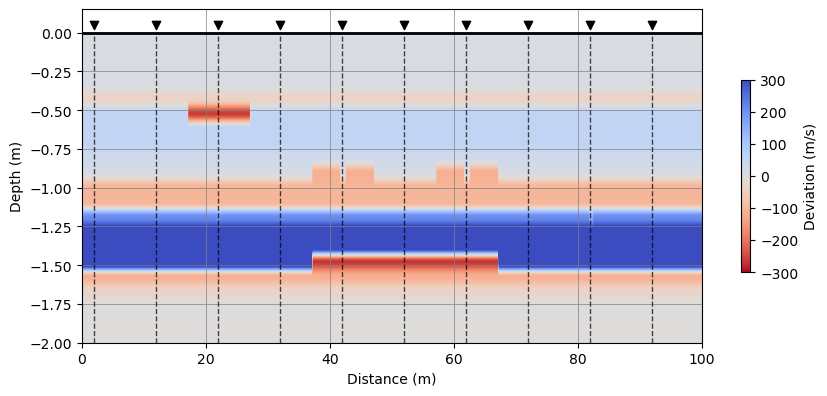

In [23]:
fig,ax = plt.subplots(1, 1, figsize=(10, 5))

im = plt.imshow(deviation_grid.velocity.data, cmap='coolwarm_r',extent=[0, 100, -2.0, 0],vmin=-300,vmax=300,aspect=25,origin='lower')

for idx,ix in enumerate(lst_receptor):
    ax.vlines(x=ix,ymin=-2.0,ymax=0,colors='k',lw=1.0,ls='--',alpha=0.7)
    ax.scatter(x=ix,y=0.05,color='k',marker='v')

ax.hlines(y=0,xmin=0,xmax=100,colors='k',lw=2,ls='-',alpha=1)
ax.set_xlabel('Distance (m)')
ax.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
ax.grid(which='minor', color='gray', linestyle=':', linewidth=0.5, alpha=0.5)
ax.set_ylabel('Depth (m)')
plt.colorbar(im, ax=ax,fraction=0.15, shrink=0.5,label='Deviation (m/s)')
fig.savefig(figures_path+'observed_slice_and_receptors.png')